# Transaction Fraud Detection - Model Evaluation
## Comprehensive Model Comparison and Analysis

This notebook performs detailed evaluation and comparison of all trained models:
- Load trained models and results
- **Validation Set Evaluation** (from training split)
- **Test Set Evaluation** (test_transaction.csv)
- Confusion matrices and classification reports
- ROC curves and PR curves comparison
- Feature importance analysis
- Threshold tuning for optimal fraud detection
- Final predictions on test data
- Model selection and recommendations

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_curve, auc, precision_recall_curve,
    average_precision_score
)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load Trained Models and Results

In [3]:
# Load all model results
with open('all_model_results.pkl', 'rb') as f:
    all_results = pickle.load(f)

# Load train/val split
with open('train_val_split.pkl', 'rb') as f:
    split_data = pickle.load(f)
    
X_val = split_data['X_val']
y_val = split_data['y_val']

print(f"✓ Loaded {len(all_results)} model results")
print(f"✓ Validation set: {X_val.shape[0]} samples")
print(f"✓ Fraud rate in validation: {y_val.mean():.2%}")

# Load label encoders and scalers used in EDA
try:
    with open('label_encoders.pkl', 'rb') as f:
        label_encoders = pickle.load(f)
    print(f"✓ Loaded {len(label_encoders)} label encoders")
except FileNotFoundError:
    label_encoders = None
    print("⚠ Label encoders not found - will process test data without them")

✓ Loaded 6 model results
✓ Validation set: 118108 samples
✓ Fraud rate in validation: 3.50%
⚠ Label encoders not found - will process test data without them


## 3. Load Test Data

In [4]:
print(f"\n{'='*100}")
print("LOADING TEST DATA")
print(f"{'='*100}\n")

# Load test transaction data
test_data = pd.read_csv('test_transaction.csv')
print(f"✓ Test data loaded: {test_data.shape}")

# Check if test data has target variable
has_test_target = 'isFraud' in test_data.columns

if has_test_target:
    print(f"✓ Test data includes target variable 'isFraud'")
    X_test = test_data.drop(columns=['isFraud'])
    y_test = test_data['isFraud']
    print(f"  Test fraud rate: {y_test.mean():.2%}")
else:
    print(f"⚠ Test data does not include target variable (prediction only)")
    X_test = test_data.copy()
    y_test = None

# Store TransactionID if present
if 'TransactionID' in X_test.columns:
    test_transaction_ids = X_test['TransactionID'].copy()
    print(f"✓ Stored {len(test_transaction_ids)} transaction IDs for predictions")
else:
    test_transaction_ids = None

# Remove ID columns
id_cols = ['TransactionID', 'TransactionDT']
X_test = X_test.drop(columns=[col for col in id_cols if col in X_test.columns], errors='ignore')

# Handle missing values (same as training)
X_test = X_test.fillna(0)

# Select only numeric columns (same as training)
X_test = X_test.select_dtypes(include=[np.number])

# Ensure test data has same columns as validation data
missing_cols = set(X_val.columns) - set(X_test.columns)
extra_cols = set(X_test.columns) - set(X_val.columns)

if missing_cols:
    print(f"\n⚠ Adding {len(missing_cols)} missing columns to test data (filled with 0)")
    for col in missing_cols:
        X_test[col] = 0

if extra_cols:
    print(f"⚠ Removing {len(extra_cols)} extra columns from test data")
    X_test = X_test.drop(columns=list(extra_cols))

# Reorder columns to match training data
X_test = X_test[X_val.columns]

print(f"\n✓ Test data preprocessed: {X_test.shape}")
print(f"  Features: {X_test.shape[1]}")
print(f"  Samples: {X_test.shape[0]:,}")
print(f"  Matches training features: {list(X_test.columns) == list(X_val.columns)}")


LOADING TEST DATA

✓ Test data loaded: (506691, 393)
⚠ Test data does not include target variable (prediction only)
✓ Test data loaded: (506691, 393)
⚠ Test data does not include target variable (prediction only)
✓ Stored 506691 transaction IDs for predictions
✓ Stored 506691 transaction IDs for predictions

⚠ Adding 34 missing columns to test data (filled with 0)

⚠ Adding 34 missing columns to test data (filled with 0)

✓ Test data preprocessed: (506691, 411)
  Features: 411
  Samples: 506,691
  Matches training features: True

✓ Test data preprocessed: (506691, 411)
  Features: 411
  Samples: 506,691
  Matches training features: True


## 4. Performance Summary - Validation Set

In [5]:
# Create summary DataFrame
summary_df = pd.DataFrame([{
    'Model': r['model_name'],
    'Accuracy': f"{r['accuracy']:.4f}",
    'Precision': f"{r['precision']:.4f}",
    'Recall': f"{r['recall']:.4f}",
    'F1-Score': f"{r['f1']:.4f}",
    'ROC-AUC': f"{r['roc_auc']:.4f}" if r['roc_auc'] else 'N/A',
    'Training Time': f"{r['training_time']:.2f}s"
} for r in all_results])

print(f"\n{'='*100}")
print("MODEL PERFORMANCE SUMMARY")
print(f"{'='*100}\n")
print(summary_df.to_string(index=False))

# Highlight best performers
print(f"\n{'='*100}")
print("🏆 BEST PERFORMERS")
print(f"{'='*100}")

metrics = ['f1', 'recall', 'precision', 'roc_auc']
metric_names = ['F1-Score', 'Recall (Fraud Detection)', 'Precision', 'ROC-AUC']

for metric, name in zip(metrics, metric_names):
    if metric == 'roc_auc':
        valid_results = [r for r in all_results if r[metric] is not None]
        if not valid_results:
            continue
        best = max(valid_results, key=lambda x: x[metric])
    else:
        best = max(all_results, key=lambda x: x[metric])
    print(f"Best {name:25s}: {best['model_name']:30s} ({best[metric]:.4f})")


MODEL PERFORMANCE SUMMARY

              Model Accuracy Precision Recall F1-Score ROC-AUC Training Time
Logistic Regression   0.7809    0.1024 0.6780   0.1780  0.7945       253.79s
      Decision Tree   0.9378    0.2997 0.5812   0.3955  0.8519        64.96s
      Random Forest   0.9740    0.6471 0.5669   0.6043  0.9201       200.18s
            XGBoost   0.9830    0.8164 0.6627   0.7316  0.9624        76.81s
           LightGBM   0.9750    0.6616 0.5846   0.6207  0.9340        34.55s
  Gradient Boosting   0.9818    0.9073 0.5352   0.6733  0.9477       602.36s

🏆 BEST PERFORMERS
Best F1-Score                 : XGBoost                        (0.7316)
Best Recall (Fraud Detection) : Logistic Regression            (0.6780)
Best Precision                : Gradient Boosting              (0.9073)
Best ROC-AUC                  : XGBoost                        (0.9624)


## 5. Confusion Matrices - Validation Set

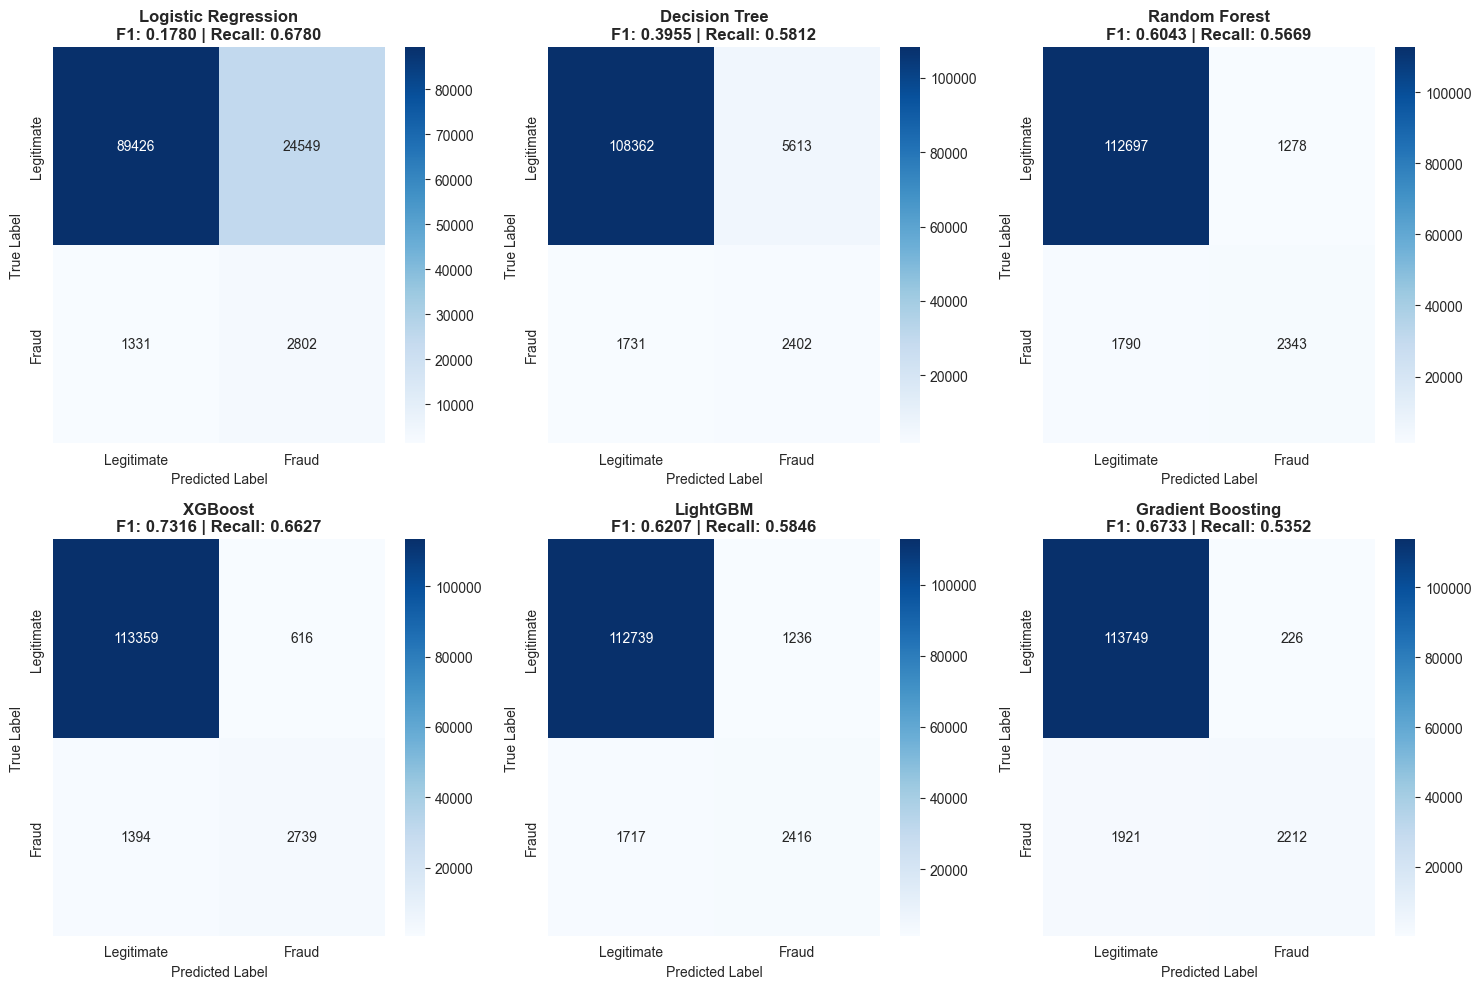

✓ Confusion matrices saved: confusion_matrices_comparison.png


In [6]:
# Plot confusion matrices for all models
n_models = len(all_results)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

for idx, result in enumerate(all_results):
    cm = result['confusion_matrix']
    ax = axes[idx]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'])
    
    ax.set_title(f"{result['model_name']}\nF1: {result['f1']:.4f} | Recall: {result['recall']:.4f}", 
                 fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

# Hide extra subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices saved: confusion_matrices_comparison.png")

## 6. Test Set Evaluation

In [7]:
print(f"\n{'='*100}")
print("EVALUATING MODELS ON TEST DATA")
print(f"{'='*100}\n")

# Make predictions on test data for all models
test_results = []

for result in all_results:
    model = result['model']
    model_name = result['model_name']
    
    print(f"Predicting with {model_name}...")
    
    # Make predictions
    y_test_pred = model.predict(X_test)
    
    # Get probabilities if available
    if hasattr(model, 'predict_proba'):
        y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_test_pred_proba = model.decision_function(X_test)
    else:
        y_test_pred_proba = None
    
    test_result = {
        'model_name': model_name,
        'y_pred': y_test_pred,
        'y_pred_proba': y_test_pred_proba
    }
    
    # If test data has labels, calculate metrics
    if has_test_target:
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
        
        test_result['accuracy'] = accuracy_score(y_test, y_test_pred)
        test_result['precision'] = precision_score(y_test, y_test_pred, zero_division=0)
        test_result['recall'] = recall_score(y_test, y_test_pred, zero_division=0)
        test_result['f1'] = f1_score(y_test, y_test_pred, zero_division=0)
        
        if y_test_pred_proba is not None:
            try:
                test_result['roc_auc'] = roc_auc_score(y_test, y_test_pred_proba)
            except:
                test_result['roc_auc'] = None
        else:
            test_result['roc_auc'] = None
        
        test_result['confusion_matrix'] = confusion_matrix(y_test, y_test_pred)
    
    test_results.append(test_result)

print(f"\n✓ Completed predictions for {len(test_results)} models on test data")

# Display test set performance if labels available
if has_test_target:
    print(f"\n{'='*100}")
    print("TEST SET PERFORMANCE SUMMARY")
    print(f"{'='*100}\n")
    
    test_summary_df = pd.DataFrame([{
        'Model': r['model_name'],
        'Accuracy': f"{r['accuracy']:.4f}",
        'Precision': f"{r['precision']:.4f}",
        'Recall': f"{r['recall']:.4f}",
        'F1-Score': f"{r['f1']:.4f}",
        'ROC-AUC': f"{r['roc_auc']:.4f}" if r['roc_auc'] else 'N/A'
    } for r in test_results])
    
    print(test_summary_df.to_string(index=False))
    
    # Compare with validation performance
    print(f"\n{'='*100}")
    print("VALIDATION vs TEST PERFORMANCE COMPARISON")
    print(f"{'='*100}\n")
    
    comparison_data = []
    for val_r, test_r in zip(all_results, test_results):
        comparison_data.append({
            'Model': val_r['model_name'],
            'Val F1': f"{val_r['f1']:.4f}",
            'Test F1': f"{test_r['f1']:.4f}",
            'F1 Diff': f"{(test_r['f1'] - val_r['f1']):.4f}",
            'Val Recall': f"{val_r['recall']:.4f}",
            'Test Recall': f"{test_r['recall']:.4f}",
            'Recall Diff': f"{(test_r['recall'] - val_r['recall']):.4f}"
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))


EVALUATING MODELS ON TEST DATA

Predicting with Logistic Regression...
Predicting with Decision Tree...
Predicting with Decision Tree...
Predicting with Random Forest...
Predicting with Random Forest...
Predicting with XGBoost...
Predicting with XGBoost...
Predicting with LightGBM...
Predicting with LightGBM...
Predicting with Gradient Boosting...
Predicting with Gradient Boosting...

✓ Completed predictions for 6 models on test data

✓ Completed predictions for 6 models on test data


In [8]:
if has_test_target:
    # Plot confusion matrices for test set
    print(f"\n{'='*100}")
    print("TEST SET - CONFUSION MATRICES")
    print(f"{'='*100}\n")
    
    n_models = len(test_results)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_models > 1 else [axes]
    
    for idx, result in enumerate(test_results):
        cm = result['confusion_matrix']
        ax = axes[idx]
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax,
                    xticklabels=['Legitimate', 'Fraud'],
                    yticklabels=['Legitimate', 'Fraud'])
        
        ax.set_title(f"{result['model_name']} (Test Set)\nF1: {result['f1']:.4f} | Recall: {result['recall']:.4f}", 
                     fontsize=12, fontweight='bold')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')
    
    # Hide extra subplots
    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices_test_set.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Test set confusion matrices saved: confusion_matrices_test_set.png")
else:
    print("\n⚠ Test set does not have labels - skipping confusion matrix visualization")


⚠ Test set does not have labels - skipping confusion matrix visualization


In [9]:
# Export predictions for all models
print(f"\n{'='*100}")
print("EXPORTING TEST PREDICTIONS")
print(f"{'='*100}\n")

# Create predictions DataFrame
predictions_dict = {}

if test_transaction_ids is not None:
    predictions_dict['TransactionID'] = test_transaction_ids

if has_test_target:
    predictions_dict['True_isFraud'] = y_test.values

for result in test_results:
    model_name = result['model_name'].replace(' ', '_')
    predictions_dict[f'{model_name}_prediction'] = result['y_pred']
    
    if result['y_pred_proba'] is not None:
        predictions_dict[f'{model_name}_probability'] = result['y_pred_proba']

predictions_df = pd.DataFrame(predictions_dict)

# Save predictions
predictions_df.to_csv('test_predictions_all_models.csv', index=False)
print(f"✓ Saved predictions for all {len(test_results)} models: test_predictions_all_models.csv")
print(f"  Rows: {len(predictions_df):,}")
print(f"  Columns: {len(predictions_df.columns)}")

# Show sample
print(f"\nSample predictions:")
print(predictions_df.head(10).to_string(index=False))


EXPORTING TEST PREDICTIONS

✓ Saved predictions for all 6 models: test_predictions_all_models.csv
  Rows: 506,691
  Columns: 13

Sample predictions:
 TransactionID  Logistic_Regression_prediction  Logistic_Regression_probability  Decision_Tree_prediction  Decision_Tree_probability  Random_Forest_prediction  Random_Forest_probability  XGBoost_prediction  XGBoost_probability  LightGBM_prediction  LightGBM_probability  Gradient_Boosting_prediction  Gradient_Boosting_probability
       3663549                               0                         0.209598                         0                   0.033076                         0                   0.228162                   0             0.025573                    0              0.236310                             0                       0.040707
       3663550                               0                         0.377920                         0                   0.033076                         0                   0.249326   

## 7. ROC Curves Comparison - Validation Set

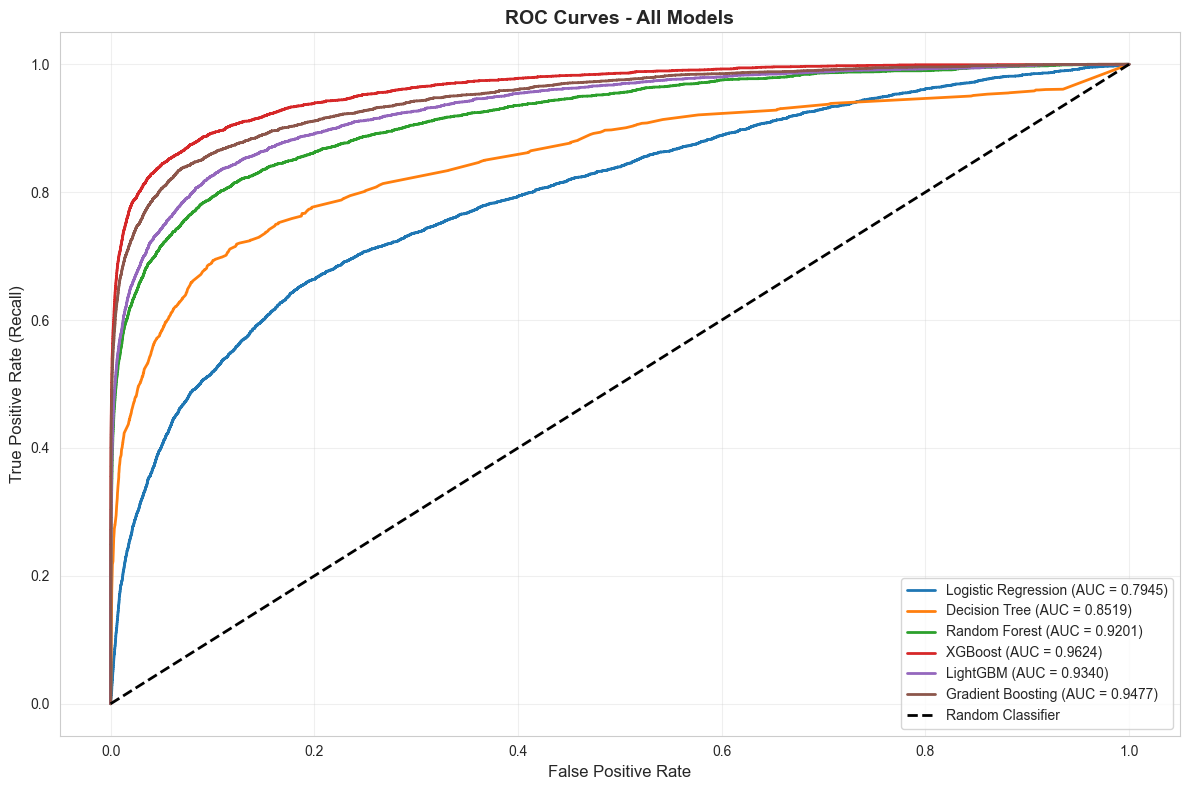

✓ ROC curves saved: roc_curves_comparison.png


In [10]:
plt.figure(figsize=(12, 8))

for result in all_results:
    if result['roc_auc'] is not None:
        fpr, tpr, _ = roc_curve(y_val, result['y_pred_proba'])
        plt.plot(fpr, tpr, linewidth=2, 
                label=f"{result['model_name']} (AUC = {result['roc_auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC curves saved: roc_curves_comparison.png")

## 8. Precision-Recall Curves - Validation Set

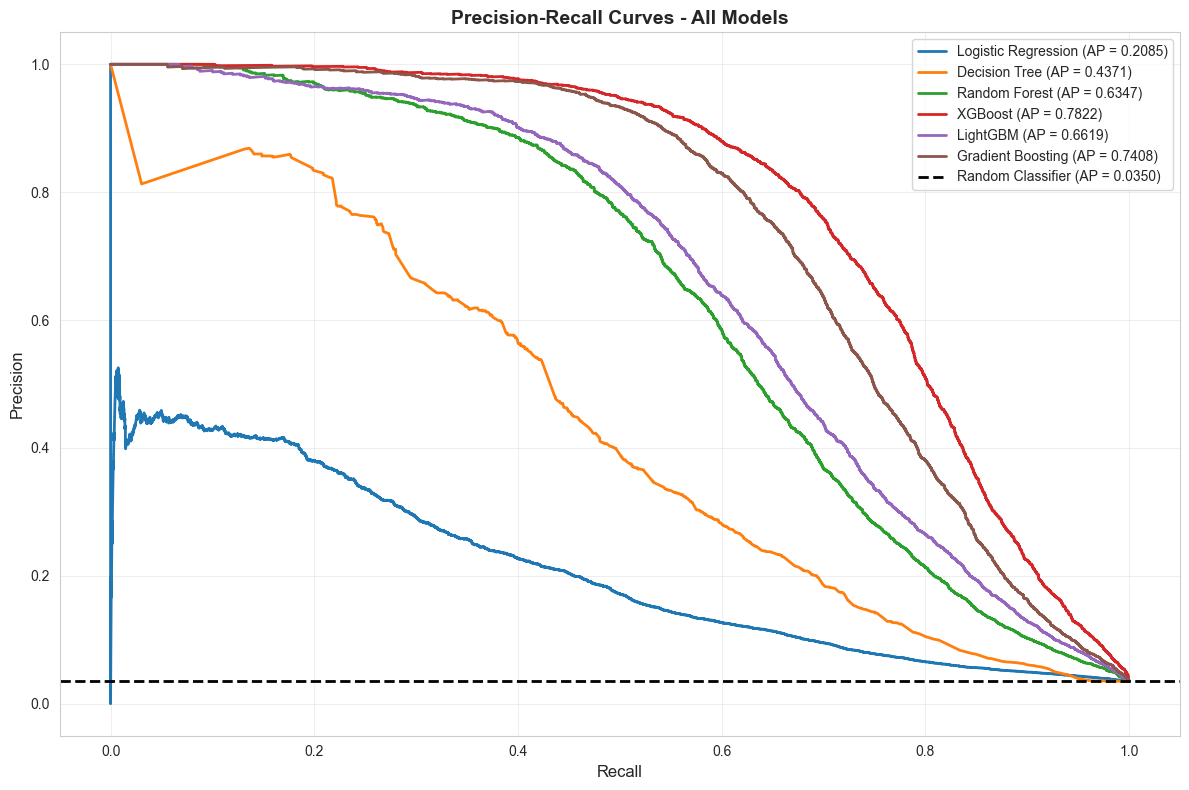

✓ Precision-Recall curves saved: precision_recall_curves.png


In [11]:
plt.figure(figsize=(12, 8))

for result in all_results:
    if result['y_pred_proba'] is not None:
        precision, recall, _ = precision_recall_curve(y_val, result['y_pred_proba'])
        avg_precision = average_precision_score(y_val, result['y_pred_proba'])
        plt.plot(recall, precision, linewidth=2,
                label=f"{result['model_name']} (AP = {avg_precision:.4f})")

# Baseline (random classifier)
baseline = y_val.mean()
plt.axhline(y=baseline, color='k', linestyle='--', linewidth=2, 
           label=f'Random Classifier (AP = {baseline:.4f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Precision-Recall curves saved: precision_recall_curves.png")

## 9. Feature Importance Analysis

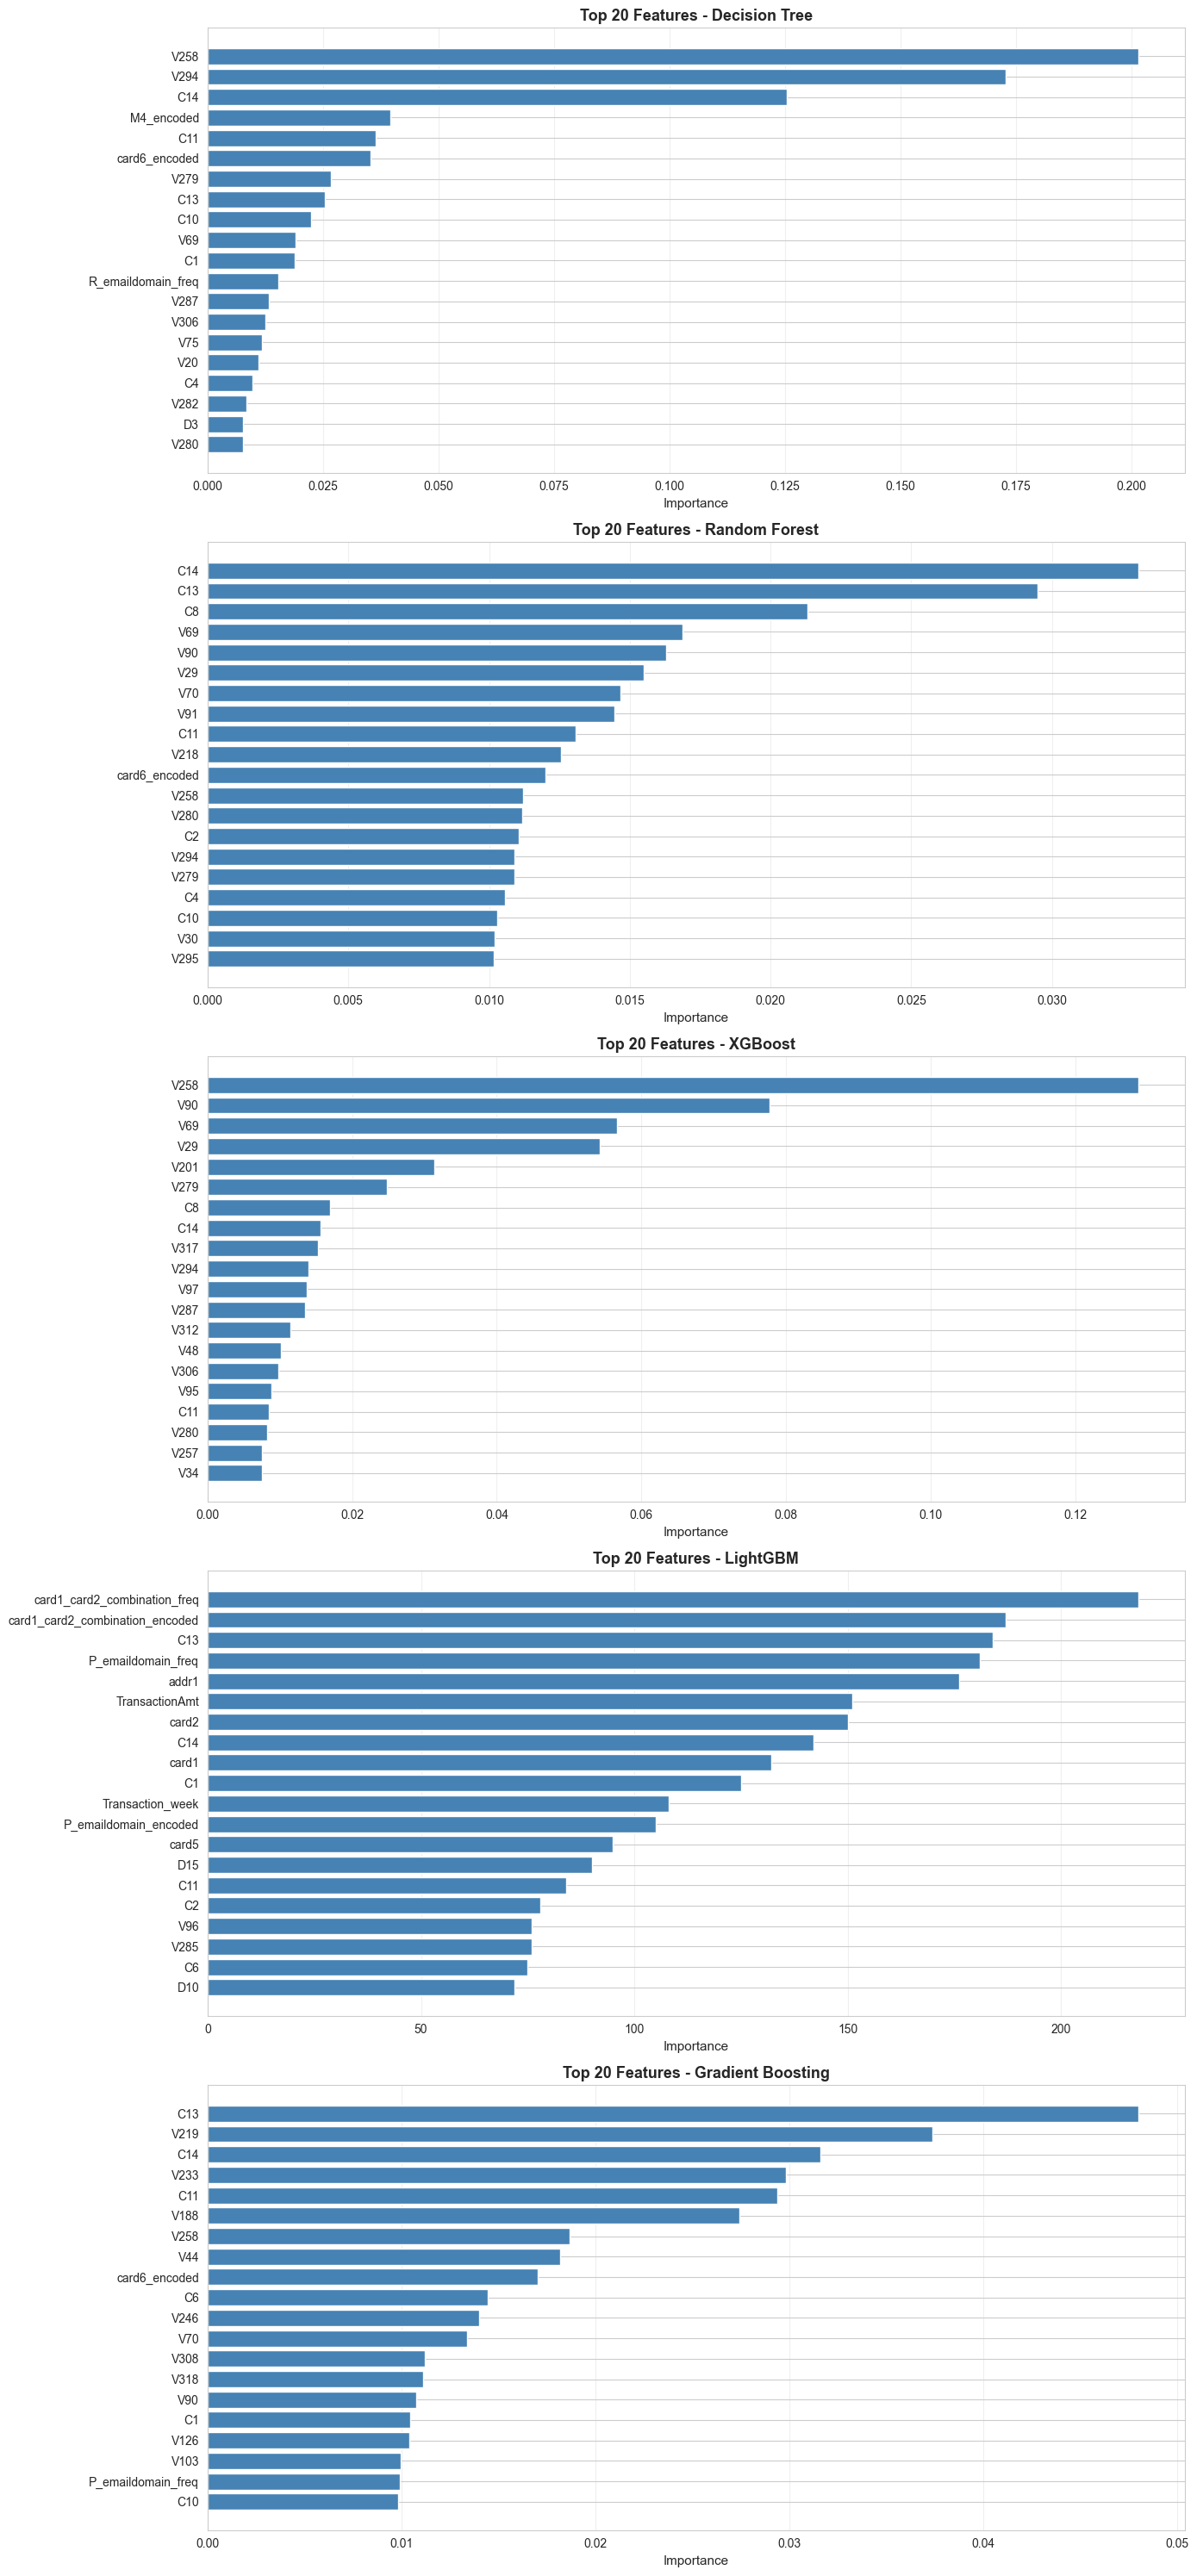

✓ Feature importance plots saved: feature_importance_comparison.png


In [12]:
# Get feature names
feature_names = X_val.columns.tolist()

# Models with feature importance
importance_models = ['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting']
importance_results = [r for r in all_results if r['model_name'] in importance_models]

if importance_results:
    n_importance_models = len(importance_results)
    fig, axes = plt.subplots(n_importance_models, 1, figsize=(14, 6*n_importance_models))
    
    if n_importance_models == 1:
        axes = [axes]
    
    for idx, result in enumerate(importance_results):
        model = result['model']
        
        # Get feature importance
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            continue
            
        # Create DataFrame and sort
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False).head(20)
        
        # Plot
        ax = axes[idx]
        ax.barh(range(len(importance_df)), importance_df['Importance'], color='steelblue')
        ax.set_yticks(range(len(importance_df)))
        ax.set_yticklabels(importance_df['Feature'])
        ax.invert_yaxis()
        ax.set_xlabel('Importance', fontsize=11)
        ax.set_title(f"Top 20 Features - {result['model_name']}", fontsize=13, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Feature importance plots saved: feature_importance_comparison.png")
else:
    print("⚠ No models with feature importance available")

## 10. Classification Reports - Validation Set

In [13]:
print(f"\n{'='*100}")
print("DETAILED CLASSIFICATION REPORTS")
print(f"{'='*100}\n")

for result in all_results:
    print(f"\n{'─'*100}")
    print(f"{result['model_name']}")
    print(f"{'─'*100}")
    print(classification_report(y_val, result['y_pred'], 
                                target_names=['Legitimate (0)', 'Fraud (1)'],
                                digits=4))


DETAILED CLASSIFICATION REPORTS


────────────────────────────────────────────────────────────────────────────────────────────────────
Logistic Regression
────────────────────────────────────────────────────────────────────────────────────────────────────
                precision    recall  f1-score   support

Legitimate (0)     0.9853    0.7846    0.8736    113975
     Fraud (1)     0.1024    0.6780    0.1780      4133

      accuracy                         0.7809    118108
     macro avg     0.5439    0.7313    0.5258    118108
  weighted avg     0.9544    0.7809    0.8492    118108


────────────────────────────────────────────────────────────────────────────────────────────────────
Decision Tree
────────────────────────────────────────────────────────────────────────────────────────────────────
                precision    recall  f1-score   support

Legitimate (0)     0.9843    0.9508    0.9672    113975
     Fraud (1)     0.2997    0.5812    0.3955      4133

      accuracy   

## 11. Threshold Tuning for Best Model


THRESHOLD TUNING: XGBoost



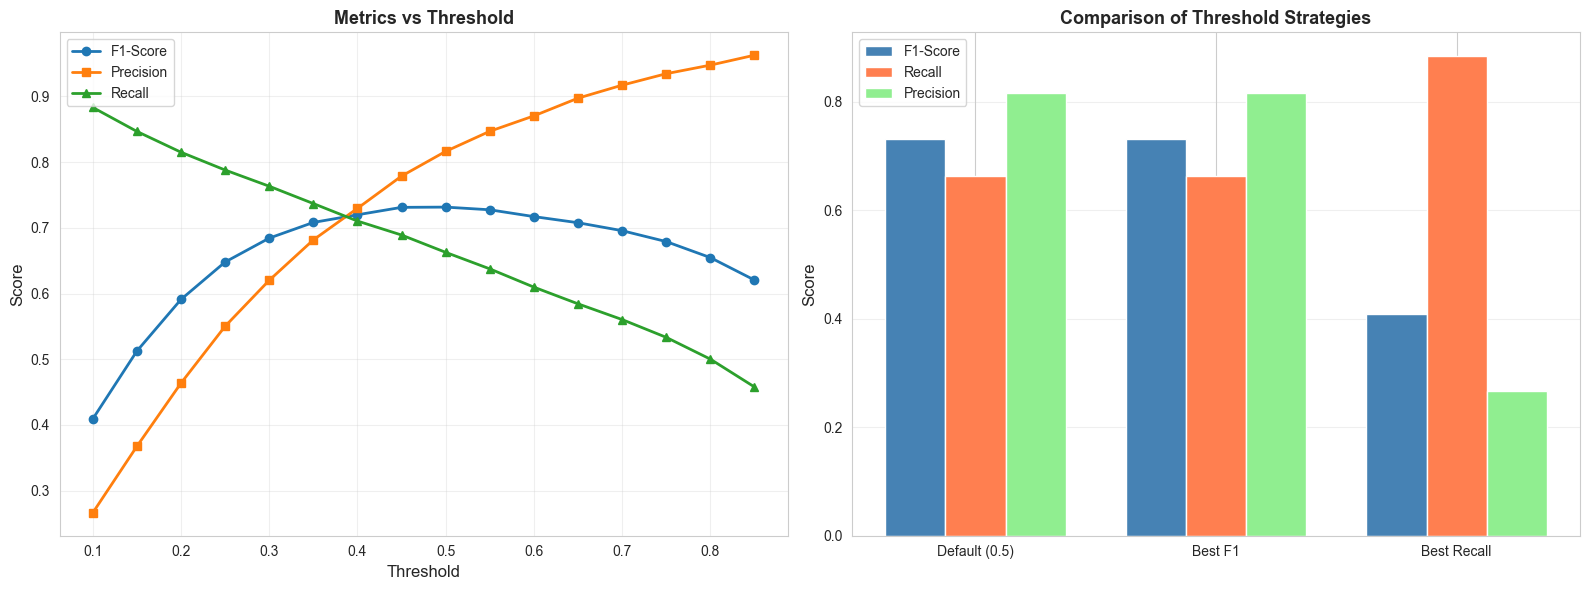

Default Threshold (0.5):
  F1-Score: 0.7316
  Precision: 0.8164
  Recall: 0.6627

Best F1-Score Threshold (0.50):
  F1-Score: 0.7316
  Precision: 0.8164
  Recall: 0.6627

Best Recall Threshold (0.10):
  F1-Score: 0.4089
  Precision: 0.2660
  Recall: 0.8834

✓ Threshold tuning analysis saved: threshold_tuning_analysis.png


In [14]:
# Find best model by F1-score
best_model_result = max(all_results, key=lambda x: x['f1'])

print(f"\n{'='*100}")
print(f"THRESHOLD TUNING: {best_model_result['model_name']}")
print(f"{'='*100}\n")

if best_model_result['y_pred_proba'] is not None:
    # Test different thresholds
    thresholds = np.arange(0.1, 0.9, 0.05)
    metrics_by_threshold = []
    
    for threshold in thresholds:
        y_pred_thresh = (best_model_result['y_pred_proba'] >= threshold).astype(int)
        
        from sklearn.metrics import f1_score, precision_score, recall_score
        
        f1 = f1_score(y_val, y_pred_thresh)
        precision = precision_score(y_val, y_pred_thresh)
        recall = recall_score(y_val, y_pred_thresh)
        
        metrics_by_threshold.append({
            'Threshold': threshold,
            'F1-Score': f1,
            'Precision': precision,
            'Recall': recall
        })
    
    threshold_df = pd.DataFrame(metrics_by_threshold)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Line plot
    ax = axes[0]
    ax.plot(threshold_df['Threshold'], threshold_df['F1-Score'], 
           marker='o', linewidth=2, label='F1-Score')
    ax.plot(threshold_df['Threshold'], threshold_df['Precision'], 
           marker='s', linewidth=2, label='Precision')
    ax.plot(threshold_df['Threshold'], threshold_df['Recall'], 
           marker='^', linewidth=2, label='Recall')
    ax.set_xlabel('Threshold', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Metrics vs Threshold', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Best thresholds
    best_f1_idx = threshold_df['F1-Score'].idxmax()
    best_recall_idx = threshold_df['Recall'].idxmax()
    
    ax = axes[1]
    bars = ['Default (0.5)', 'Best F1', 'Best Recall']
    
    default_metrics = threshold_df.iloc[(threshold_df['Threshold'] - 0.5).abs().argmin()]
    best_f1_metrics = threshold_df.iloc[best_f1_idx]
    best_recall_metrics = threshold_df.iloc[best_recall_idx]
    
    f1_scores = [default_metrics['F1-Score'], best_f1_metrics['F1-Score'], best_recall_metrics['F1-Score']]
    recalls = [default_metrics['Recall'], best_f1_metrics['Recall'], best_recall_metrics['Recall']]
    precisions = [default_metrics['Precision'], best_f1_metrics['Precision'], best_recall_metrics['Precision']]
    
    x = np.arange(len(bars))
    width = 0.25
    
    ax.bar(x - width, f1_scores, width, label='F1-Score', color='steelblue')
    ax.bar(x, recalls, width, label='Recall', color='coral')
    ax.bar(x + width, precisions, width, label='Precision', color='lightgreen')
    
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Comparison of Threshold Strategies', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(bars)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('threshold_tuning_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print results
    print(f"Default Threshold (0.5):")
    print(f"  F1-Score: {default_metrics['F1-Score']:.4f}")
    print(f"  Precision: {default_metrics['Precision']:.4f}")
    print(f"  Recall: {default_metrics['Recall']:.4f}")
    
    print(f"\nBest F1-Score Threshold ({best_f1_metrics['Threshold']:.2f}):")
    print(f"  F1-Score: {best_f1_metrics['F1-Score']:.4f}")
    print(f"  Precision: {best_f1_metrics['Precision']:.4f}")
    print(f"  Recall: {best_f1_metrics['Recall']:.4f}")
    
    print(f"\nBest Recall Threshold ({best_recall_metrics['Threshold']:.2f}):")
    print(f"  F1-Score: {best_recall_metrics['F1-Score']:.4f}")
    print(f"  Precision: {best_recall_metrics['Precision']:.4f}")
    print(f"  Recall: {best_recall_metrics['Recall']:.4f}")
    
    print("\n✓ Threshold tuning analysis saved: threshold_tuning_analysis.png")
else:
    print("⚠ Best model does not support probability predictions")

## 12. Model Comparison Visualization

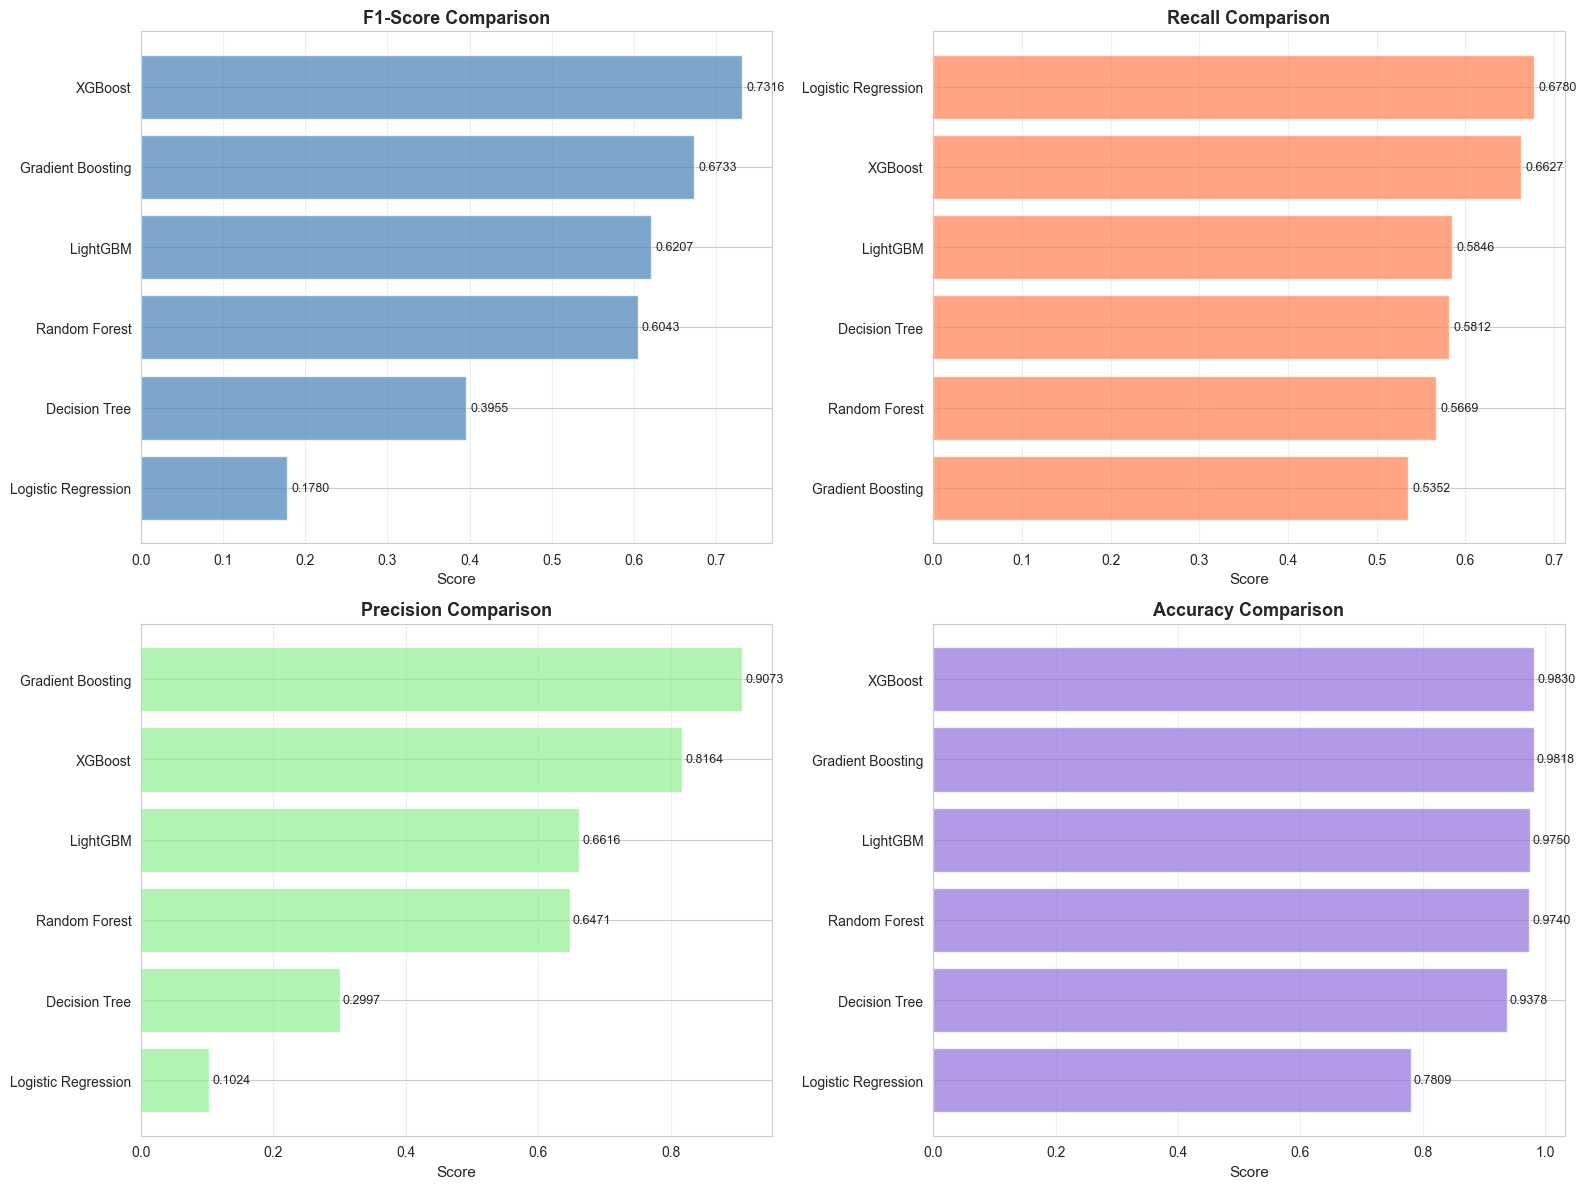

✓ Model comparison visualization saved: model_comparison_metrics.png


In [15]:
# Create comparison DataFrame
comparison_df = pd.DataFrame([{
    'Model': r['model_name'],
    'F1-Score': r['f1'],
    'Recall': r['recall'],
    'Precision': r['precision'],
    'Accuracy': r['accuracy']
} for r in all_results])

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['F1-Score', 'Recall', 'Precision', 'Accuracy']
colors = ['steelblue', 'coral', 'lightgreen', 'mediumpurple']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    
    sorted_df = comparison_df.sort_values(metric, ascending=True)
    
    ax.barh(range(len(sorted_df)), sorted_df[metric], color=color, alpha=0.7)
    ax.set_yticks(range(len(sorted_df)))
    ax.set_yticklabels(sorted_df['Model'])
    ax.set_xlabel('Score', fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(sorted_df[metric]):
        ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Model comparison visualization saved: model_comparison_metrics.png")

## 13. Final Recommendations

In [16]:
print(f"\n{'='*100}")
print("FINAL MODEL SELECTION RECOMMENDATIONS")
print(f"{'='*100}\n")

# Best by different criteria (validation set)
best_f1 = max(all_results, key=lambda x: x['f1'])
best_recall = max(all_results, key=lambda x: x['recall'])
best_precision = max(all_results, key=lambda x: x['precision'])

roc_results = [r for r in all_results if r['roc_auc'] is not None]
best_roc = max(roc_results, key=lambda x: x['roc_auc']) if roc_results else None

print("📊 Best Models by Metric (Validation Set):\n")
print(f"1. Best F1-Score (Balanced Performance):")
print(f"   Model: {best_f1['model_name']}")
print(f"   F1: {best_f1['f1']:.4f} | Precision: {best_f1['precision']:.4f} | Recall: {best_f1['recall']:.4f}\n")

print(f"2. Best Recall (Catch Most Frauds):")
print(f"   Model: {best_recall['model_name']}")
print(f"   Recall: {best_recall['recall']:.4f} | F1: {best_recall['f1']:.4f} | Precision: {best_recall['precision']:.4f}\n")

print(f"3. Best Precision (Minimize False Alarms):")
print(f"   Model: {best_precision['model_name']}")
print(f"   Precision: {best_precision['precision']:.4f} | F1: {best_precision['f1']:.4f} | Recall: {best_precision['recall']:.4f}\n")

if best_roc:
    print(f"4. Best ROC-AUC (Overall Discrimination):")
    print(f"   Model: {best_roc['model_name']}")
    print(f"   ROC-AUC: {best_roc['roc_auc']:.4f} | F1: {best_roc['f1']:.4f}\n")

# Show test set performance if available
if has_test_target and test_results:
    print(f"\n{'─'*100}\n")
    print("📊 Test Set Performance (Generalization Check):\n")
    
    best_test_f1 = max(test_results, key=lambda x: x['f1'])
    best_test_recall = max(test_results, key=lambda x: x['recall'])
    
    print(f"Best Test F1-Score: {best_test_f1['model_name']} ({best_test_f1['f1']:.4f})")
    print(f"Best Test Recall: {best_test_recall['model_name']} ({best_test_recall['recall']:.4f})")
    
    # Check for overfitting
    print(f"\n🔍 Overfitting Analysis:")
    for val_r, test_r in zip(all_results, test_results):
        f1_drop = val_r['f1'] - test_r['f1']
        status = "✓ Good" if abs(f1_drop) < 0.05 else "⚠ Check" if abs(f1_drop) < 0.10 else "❌ Overfitting"
        print(f"  {val_r['model_name']:30s}: Val F1={val_r['f1']:.4f}, Test F1={test_r['f1']:.4f}, Drop={f1_drop:+.4f} [{status}]")

print(f"\n{'─'*100}\n")
print("💡 Business Context Recommendations:\n")

print("For FRAUD DETECTION (High Stakes):")
print(f"  → Prioritize RECALL to catch maximum fraudulent transactions")
print(f"  → Recommended: {best_recall['model_name']} (Recall: {best_recall['recall']:.4f})")
print(f"  → Consider lowering threshold to increase recall further\n")

print("For BALANCED APPROACH:")
print(f"  → Use F1-Score to balance precision and recall")
print(f"  → Recommended: {best_f1['model_name']} (F1: {best_f1['f1']:.4f})")
print(f"  → Best overall performance for most use cases\n")

print("For MINIMAL FALSE ALARMS:")
print(f"  → Prioritize PRECISION when manual review is costly")
print(f"  → Recommended: {best_precision['model_name']} (Precision: {best_precision['precision']:.4f})")
print(f"  → Consider raising threshold to reduce false positives\n")

print(f"\n{'='*100}")
print("DELIVERABLES GENERATED")
print(f"{'='*100}\n")

print("📁 Validation Set Analysis:")
print("   • confusion_matrices_comparison.png - Validation confusion matrices")
print("   • roc_curves_comparison.png - ROC curves for all models")
print("   • precision_recall_curves.png - PR curves for all models")
print("   • feature_importance_comparison.png - Top features per model")
print("   • threshold_tuning_analysis.png - Optimal threshold analysis")
print("   • model_comparison_metrics.png - Side-by-side metric comparison")

if has_test_target:
    print("\n📁 Test Set Analysis:")
    print("   • confusion_matrices_test_set.png - Test set confusion matrices")
    print("   • test_predictions_all_models.csv - All model predictions with probabilities")
else:
    print("\n📁 Test Set Predictions:")
    print("   • test_predictions_all_models.csv - Predictions for test_transaction.csv")

print(f"\n{'='*100}")
print("NEXT STEPS")
print(f"{'='*100}\n")

print("1. ✓ Review validation and test performance comparison")
print("2. ✓ Select best model based on business requirements")
print("3. ✓ Use test_predictions_all_models.csv for submission/deployment")
print("4. Monitor model performance in production")
print("5. Consider ensemble methods combining top models")
print("6. Implement threshold tuning in production based on cost-benefit analysis\n")

print(f"{'='*100}")
print("✅ EVALUATION COMPLETE - Models evaluated on BOTH validation and test sets!")
print(f"{'='*100}")


FINAL MODEL SELECTION RECOMMENDATIONS

📊 Best Models by Metric (Validation Set):

1. Best F1-Score (Balanced Performance):
   Model: XGBoost
   F1: 0.7316 | Precision: 0.8164 | Recall: 0.6627

2. Best Recall (Catch Most Frauds):
   Model: Logistic Regression
   Recall: 0.6780 | F1: 0.1780 | Precision: 0.1024

3. Best Precision (Minimize False Alarms):
   Model: Gradient Boosting
   Precision: 0.9073 | F1: 0.6733 | Recall: 0.5352

4. Best ROC-AUC (Overall Discrimination):
   Model: XGBoost
   ROC-AUC: 0.9624 | F1: 0.7316


────────────────────────────────────────────────────────────────────────────────────────────────────

💡 Business Context Recommendations:

For FRAUD DETECTION (High Stakes):
  → Prioritize RECALL to catch maximum fraudulent transactions
  → Recommended: Logistic Regression (Recall: 0.6780)
  → Consider lowering threshold to increase recall further

For BALANCED APPROACH:
  → Use F1-Score to balance precision and recall
  → Recommended: XGBoost (F1: 0.7316)
  → Best o